In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from IPython.display import clear_output
from keras.callbacks import Callback  
from keras.callbacks import ReduceLROnPlateau
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, BatchNormalization, Activation, Dropout, Conv2D, MaxPooling2D, Reshape, UpSampling2D
from keras.optimizers import Adam
from tensorflow.keras.utils import img_to_array, load_img

In [3]:
class PlotLosses(Callback):
    def __init__(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        fig, axes = plt.subplots(1,2,figsize=(8,3))
        
        axes[0].plot(self.x, self.losses, label="Train loss")
        axes[0].plot(self.x, self.val_losses, label="Validation loss")
        #axes[0].set_yscale('log')
        axes[0].set_xlabel('Number of epochs')
        axes[0].set_ylabel('Losses')
        axes[0].legend()
            
        axes[1].plot(self.x, self.acc, label="Train accuracy")
        axes[1].plot(self.x, self.val_acc, label="Validation accuracy")
        axes[1].set_xlabel('Number of epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        
        plt.tight_layout()
        plt.show();

In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True, vertical_flip=True, validation_split=0.2, rotation_range=360.)

train_generator = train_datagen.flow_from_directory(
    directory='images',
    class_mode='categorical',
    batch_size=32,
    target_size=(32, 32),
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    directory='images',
    class_mode='categorical',
    batch_size=32,
    target_size=(32, 32),
    subset='validation'
)

Found 1652 images belonging to 4 classes.
Found 411 images belonging to 4 classes.


In [5]:
with open('training_galaxies.dat') as f:
    names = f.readline().rstrip().strip("#").split()
    df = pd.read_csv(f, sep=r'\s+', names=names)
df.info()

gal_type = df['gal_type']
df = df.drop('gal_type', axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2063 entries, 0 to 2062
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2063 non-null   int64  
 1   gal_type        2063 non-null   int64  
 2   ra              2063 non-null   float64
 3   dec             2063 non-null   float64
 4   redshift        2063 non-null   float64
 5   log_luminosity  2063 non-null   float64
 6   color           2063 non-null   float64
 7   radius          2063 non-null   float64
 8   b_over_a        2063 non-null   float64
 9   pos_angle       2063 non-null   float64
 10  bulge_fract     2063 non-null   float64
 11  sersic_n        2063 non-null   float64
 12  r_bulge         2063 non-null   float64
 13  r_disk          2063 non-null   float64
dtypes: float64(12), int64(2)
memory usage: 225.8 KB


In [8]:
def train_cnn(train_generator, val_generator):
    plot_losses = PlotLosses()
    x = Input(shape=(32,32,3))
    h = Conv2D(filters = 128, kernel_size=(2,2), activation='relu')(x)
    h = Conv2D(filters = 64, kernel_size=(3,3), activation='relu')(h)
    h = Dropout(rate = 0.1)(h)
    h = MaxPooling2D((2,2))(h)
    h = Conv2D(filters = 64, kernel_size=(4,4), activation='relu')(h)
    h = Conv2D(filters=32,kernel_size=(4,4), activation='relu')(h)
    h = Flatten()(h)
    h = Dropout(rate = 0.1)(h)
    h = Dense(128,activation='relu')(h)
    h = Dense(64,activation='relu')(h)
    h = Dense(32,activation='relu')(h)
    y = Dense(4,activation='softmax')(h)
    model = Model(x,y)
    model.compile(optimizer=Adam(learning_rate=0.003), loss='categorical_crossentropy', metrics =['accuracy'])
    model.fit(train_generator, validation_data=val_generator, epochs = 40, 
              callbacks=[plot_losses])
    return model

def cnn_predict(cnn, images):
    images /= 255.
    pred = cnn.predict(images)
    gal_predictions = []
    for i in pred:
        category = np.argmax(i) + 1
        gal_predictions.append(category)
        
    return np.asarray(gal_predictions)

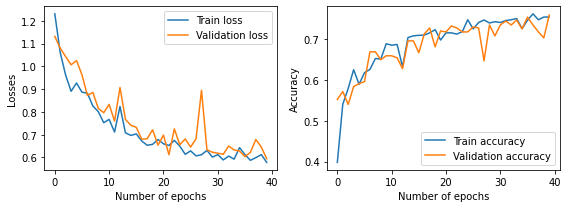

33/33 [==============================] - 1s 35ms/step
Num correct =  798
Num total =  1032
Fraction correct =  0.7732558139534884


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(df, gal_type, test_size = 0.5, random_state=1234)

cnn = train_cnn(train_generator, val_generator)

test_images = np.array([img_to_array(load_img('images/{}/{}.jpg'.format(gt, ID), target_size=(32,32))) 
                        for gt,ID in zip(Y_test, X_test['id'])])

Y_pred = cnn_predict(cnn, test_images)

print('Num correct = ',np.sum(Y_pred == Y_test))
print('Num total = ',len(Y_test))
print('Fraction correct = ',np.sum(Y_pred == Y_test) / len(Y_test))
